##### 這邊先圖資料然後因為原始資料是圖片所以我把它變成dataframe

- 然後順便他把變成灰階

In [2]:
import os
import cv2
import numpy as np

DATA_DIR = "flowers"
IMG_SIZE = 128


X = []
y = []

label_map = {
    "daisy": 0,
    "dandelion": 1,
    "rose": 2,
    "sunflower": 3,
    "tulip": 4
}
# 這邊是把圖片變成向量 就類似csv
for label_name, label in label_map.items():
    folder = os.path.join(DATA_DIR, label_name)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 這邊可以變成灰階
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # 這邊是用來變成128*128
        X.append(img.flatten())   # 128×128 → 16384
        y.append(label)

# 這邊把它變成numpy
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(4317, 16384) (4317,)


###### 拿出其中一個看看 

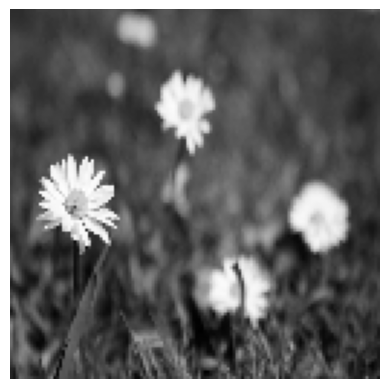

花朵編號： 0


In [6]:
# 會發現多一個因為是欄位名裡面是 0 1 2 3 4 5 6 
# 所以要用掉
import matplotlib.pyplot as plt
import numpy as np
image = X[100,:].reshape(128,128)
plt.imshow(image , cmap='gray')
plt.axis('off')
plt.show()
print('花朵編號：' , y[100])


- 先來做做看單純集群分析（沒做pca或是lda之類的）

In [3]:
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Heiti TC'  # 或 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False   # 解決負號顯示成方框



- 因為樣本數有點多四千多張所以先拿幾張做Hierarchical clustering

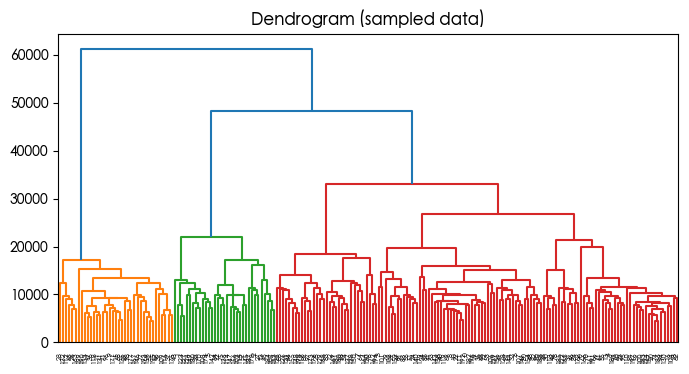

In [4]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

idx = np.random.choice(len(X), size=200, replace=False)

linked_sub = linkage(X[idx], method='ward')

plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=None   # 先畫完整樹
)
plt.title("Dendrogram (sampled data)")
plt.show()


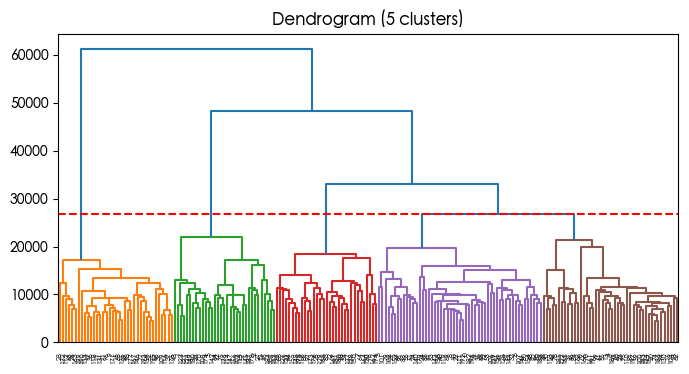

In [5]:
plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=linked_sub[-4, 2]  # 關鍵這一行
)
plt.title("Dendrogram (5 clusters)")
cut_height = linked_sub[-4, 2]
plt.axhline(y=cut_height, color='r', linestyle='--')
plt.show()


- 這邊是來驗證正確程度

In [6]:
from scipy.cluster.hierarchy import linkage

linked = linkage(X, method='ward')
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(linked, t=5, criterion='maxclust')

print(cluster_labels.shape)  # (4317,)
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)



(4317,)
Adjusted Rand Index (ARI): 0.01619230432399665


- 這邊可以看到效果很差

In [7]:
import pandas as pd

ct = pd.crosstab(
    cluster_labels,
    y,
    rownames=["Cluster"],
    colnames=["True Label"]
)

print(ct)


True Label    0    1    2    3    4
Cluster                            
1            46   36   32   22   39
2           126  235  176  347  271
3           279  393  284  276  438
4           116  145  132   23   62
5           197  243  160   65  174


- 這上面可以看出來分得非常差 因為都分散在不同類

<hr>

- 這邊來試試看k-means

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=20
)

kmeans_labels = kmeans.fit_predict(X)


- 一樣看看分數

In [9]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y, kmeans_labels)
print("KMeans ARI:", ari_kmeans)


KMeans ARI: 0.016715355188845236


In [10]:
import pandas as pd

ct_kmeans = pd.crosstab(
    kmeans_labels,
    y,
    rownames=["KMeans Cluster"],
    colnames=["True Label"]
)

print(ct_kmeans)


True Label        0    1    2    3    4
KMeans Cluster                         
0               141  175  161   34  119
1                95  107   92  121   87
2                59  123  109  207  223
3               262  366  264  140  360
4               207  281  158  231  195


- 可以發現還是分得非常差

In [12]:
from sklearn_extra.cluster import KMedoids

In [ ]:
kmedoids = KMedoids(
    n_clusters=5,
    metric="euclidean",
    random_state=42,
    method="pam"
)

kmedoids_labels = kmedoids.fit_predict(X)


In [14]:
ari_kmedoids = adjusted_rand_score(y, kmedoids_labels)
print("KMedoids ARI:", ari_kmedoids)


KMedoids ARI: 0.016174766547658023


In [15]:
ct_kmedoids = pd.crosstab(
    kmedoids_labels,
    y,
    rownames=["KMedoids Cluster"],
    colnames=["True Label"]
)

print(ct_kmedoids)


True Label          0    1    2    3    4
KMedoids Cluster                         
0                  54  102   94  143  192
1                 313  391  322  105  338
2                  86  142  104  193  120
3                 251  368  224  260  289
4                  60   49   40   32   45


- 這樣是可以預期的不管用什麼方式效果都很差

- 來試試看上課沒有教得分群方式

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=10,        # 這個要調
    min_samples=5  # 常見 5~20
)

db_labels = dbscan.fit_predict(X)


- 看他分了幾群

In [27]:
import numpy as np

unique_labels = np.unique(db_labels)
print("Unique cluster labels:", unique_labels)

n_clusters = len(unique_labels[unique_labels != -1])
n_noise = np.sum(db_labels == -1)

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)


Unique cluster labels: [-1]
Number of clusters: 0
Number of noise points: 4317


- 他會差是很正常的因為都分在一塊了

In [21]:
from sklearn.metrics import adjusted_rand_score

ari_dbscan = adjusted_rand_score(y, db_labels)
print("DBSCAN ARI:", ari_dbscan)


DBSCAN ARI: 0.0


In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_lda = lda.fit_transform(X, y)

print("LDA 後維度:", X_lda.shape)


LDA 後維度: (4317, 4)


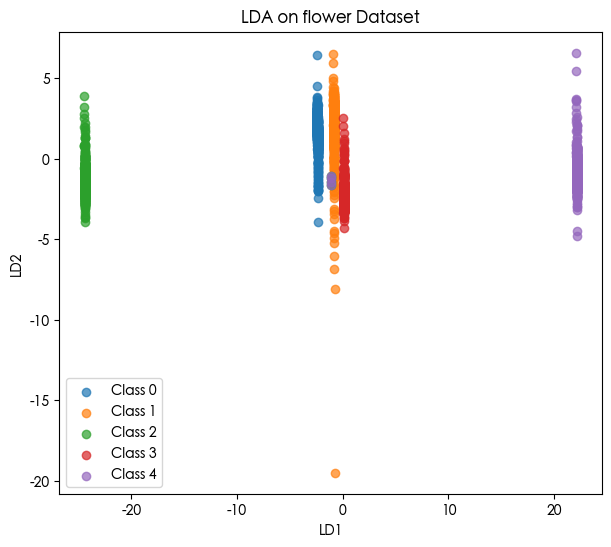

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

for label in [0, 1, 2 , 3 , 4]:
    plt.scatter(
        X_lda[y == label, 0],
        X_lda[y == label, 1],
        label=f"Class {label}",
        alpha=0.7
    )

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA on flower Dataset")
plt.legend()
plt.show()


In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 建立 LDA 模型
# 預設 solver 為 'svd'，通常不需要特別設定 random_state 或 max_iter
lda = LinearDiscriminantAnalysis()

lda.fit(X, y)                 # 訓練
lda_labels = lda.predict(X)   # 預測

print(lda_labels.shape)

(4317,)


In [4]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y, lda_labels))


Accuracy: 0.9719712763493167


In [5]:
from sklearn.metrics import adjusted_rand_score
print("ARI:", adjusted_rand_score(y, lda_labels))


ARI: 0.9324014529312005


- 這邊可以看到做lda準確度也很高

- 這邊想要跑統計的lda但是col太多他會跑不動

In [35]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA

# X: numpy array (n_samples, n_features)
# y: labels (n_samples,)

df_stats = pd.DataFrame(
    X,
    columns=[f"x{i}" for i in range(X.shape[1])]
)

df_stats["target"] = y.astype(str)

formula = " + ".join(df_stats.columns[:-1]) + " ~ target"

maov = MANOVA.from_formula(formula, data=df_stats)
print(maov.mv_test())


RecursionError: maximum recursion depth exceeded

- 這邊可以稍微看到準確度有上升

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

eigenvalues = lda.explained_variance_ratio_ / (1 - lda.explained_variance_ratio_)
canonical_r2 = eigenvalues / (1 + eigenvalues)

print("Eigenvalues:", eigenvalues)
print("Canonical R²:", canonical_r2)


Eigenvalues: [2.60315263e+01 1.46649408e-02 1.19920440e-02 1.08064448e-02]
Canonical R²: [0.96300616 0.01445299 0.01184994 0.01069091]


- 這邊可以看到一個維度就可以分得不錯了

<hr>

- 現在做做看logistic

In [38]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=2000,
    random_state=42
)

logistic.fit(X, y)                 # 訓練
logistic_labels = logistic.predict(X)  # 預測

print(logistic_labels.shape)


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


(4317,)


In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y, logistic_labels))


Accuracy: 0.9990734306231179


In [40]:
from sklearn.metrics import adjusted_rand_score
print("ARI:", adjusted_rand_score(y, logistic_labels))


ARI: 0.9976704829576556


- 這邊是比較機器學習的方式 我們要換成統計一點的logistic
- 但這邊效果其實蠻好的

- 這下面也跑不動因為太大了 蠻正常的

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1) 加截距項
X_stats = sm.add_constant(X, has_constant="add")
y_stats = y

# 2) 建模與擬合
model = sm.MNLogit(y_stats, X_stats)
result = model.fit(method="bfgs", maxiter=200, disp=False)

# 3) 用機率做預測（MNLogit 的核心）
probs = np.asarray(result.predict(X_stats))  # shape: (n_samples, n_classes)
y_pred = probs.argmax(axis=1)

# 4) 準確率
acc = (y_pred == y_stats).mean()
print("In-sample accuracy:", acc)

# 5) 混淆矩陣（交叉表）
ct = pd.crosstab(y_pred, y_stats, rownames=["Pred"], colnames=["True"])
print(ct)

# 6) 統計上的 fit 指標
print("llf (log-likelihood):", result.llf)
print("llnull (null ll):", result.llnull)
print("McFadden pseudo-R2:", result.prsquared)
print("LR test stat (llr):", result.llr)
print("LR test p-value:", result.llr_pvalue)
print("AIC:", result.aic)
print("BIC:", result.bic)


: 